In [6]:
import pandas as pd
import numpy as np
#import tensorflow as tf
from copy import deepcopy
import matplotlib.pyplot as plt

In [3]:
%%time
df = pd.read_csv("../input/data/blocks.csv")

CPU times: user 367 ms, sys: 103 ms, total: 470 ms
Wall time: 438 ms


In [4]:
print(df.shape)
df.head()

(2273345, 7)


,Level,latBlock,lngBlock,month,day,hour,ClientMacAddr
0,0,0,20,4,1,10,1
1,0,0,20,4,2,16,1
2,0,0,20,4,3,10,1
3,0,0,20,4,3,16,1
4,0,0,20,4,3,17,1


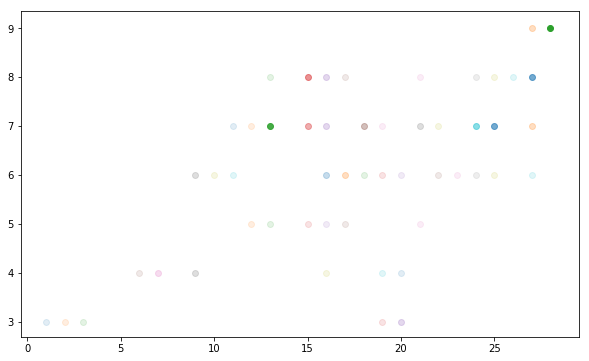

In [38]:
plt.figure(figsize=(10,6))
for i,r in df[(df.Level==5)&(df.month==4)&(df.day==25)&(df.hour==12)].iterrows():
    plt.scatter(r.lngBlock,
                r.latBlock,
                alpha=r.ClientMacAddr/8)
plt.show()

In [37]:
df[(df.Level==5)&(df.month==4)&(df.day==25)&(df.hour==12)].ClientMacAddr.max()

8

In [39]:
pd.set_option('display.max_rows',400)
df[df.Level==5].groupby(by=['latBlock','lngBlock']).agg({"ClientMacAddr":"mean"}).\
reset_index().sort_values(by="ClientMacAddr",ascending=False).head(400)

,latBlock,lngBlock,ClientMacAddr
117,6,9,12.713294
140,7,13,7.975971
177,9,28,7.832742
141,7,14,7.088768
157,8,14,6.754955
158,8,15,6.323576
176,9,27,5.774989
164,8,21,5.480586
143,7,16,5.194710
142,7,15,5.098344


In [4]:
df_val = df.loc[df.month>=6]
df = df.loc[df.month<6]
print(df_val.shape)
print(df.shape)

(3858677, 9)
(6187814, 9)


In [5]:
%%time
# format the input and output
def matrixTrans(df, level, between=7):
    tf = deepcopy(df.loc[df['Level'] == level])
    latMax = tf.latBlock.max()+1
    lngMax = tf.lngBlock.max()+1
    tf["order"] = tf.month * 10**2+ tf.day
    orders = sorted(tf["order"].unique())

    def generator():
        for hour in tf.hour.unique():
            for minute in tf.minute.unique():
                yield hour,minute

    g = generator()
    num = 0
    for h,m in g:
        num+= len(orders)-between
    features = np.zeros((num,lngMax,latMax,between))
    labels = np.zeros((num,lngMax,latMax))

    g = generator()
    index = 0
    for hour,minute in g:
        temp = tf.loc[(tf.hour==hour)&(tf.minute==minute)]
        for i in range(between, len(orders)):
            next_ = temp.loc[tf.order==orders[i]]
            for _,row in next_.iterrows():
                labels[index, row['lngBlock'],row['latBlock']] = row['count']
            for b in range(between):
                prev = temp.loc[tf.order==orders[i-1-b]]
                for _, row in prev.iterrows():
                    features[index, row['lngBlock'],row['latBlock'],b] = row['count']
            index += 1
            if index==num:
                return features, labels

    del tf
    features = features[:index,:,:,:]
    labels = labels[:index,:,:]
    return features, labels

features, labels = matrixTrans(df, 0)
features_val, labels_val = matrixTrans(df_val, 0)
print(features.shape)
print(labels.shape)

(4896, 50, 50, 7)
(4896, 50, 50)
Wall time: 21min 51s


In [57]:
def cnn_model(features, labels, mode):
    # Input Layer
    size = features.shape
    kernel_size = [(3,3),(2,2),(2,2),(1,1)]
    #pool_size = parameters.get("pool_size", [(2,2),(3,3),(2,2)])
    strides = [1,1,1]
    filters = [64, 32, 32,1]

    input_layer = tf.reshape(features, [-1, size[1], size[2], size[3]])
    label_layer = tf.reshape(labels, [-1, size[1]*size[2]])

    # We only add conv layers with 'same' padding in our model
    # since It's a n*n -> n*n prediction (previous distribution -> future prediction)
    # dimensions should be kept same

    # Convolutional Layer and Pooling Layer#1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=filters[0],
      kernel_size=kernel_size[0],
      padding="same",
      activation=tf.nn.elu)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=conv1,
      filters=filters[1],
      kernel_size=kernel_size[1],
      padding="same",
      activation=tf.nn.elu)
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv3 = tf.layers.conv2d(
      inputs=conv2,
      filters=filters[2],
      kernel_size=kernel_size[2],
      padding="same",
      activation=tf.nn.elu)
    
    conv4 = tf.layers.conv2d(
      inputs=conv3,
      filters=filters[3],
      kernel_size=kernel_size[3],
      padding="same",
      activation=tf.nn.relu)

    # Dense Layer
    conv4_flat = tf.reshape(conv4, [-1, size[1]*size[2]*filters[3]])
    #dense = tf.layers.dense(inputs=conv3_flat, units=1024)
    #dropout = tf.layers.dropout(inputs=dense, rate=0.8, training= mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = conv4_flat # tf.layers.dense(inputs=dropout, units= size[1]*size[2], activation=tf.nn.relu)

    # Loss
    loss = tf.losses.mean_squared_error(labels=label_layer, predictions=logits)
    
    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "distribution": logits
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "mse": tf.metrics.mean_squared_error(
          labels=label_layer, predictions=logits)
    }
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [58]:
# Build the estimator
distribution_estimator = tf.estimator.Estimator(
    model_fn=cnn_model)
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=features,
    y=labels,
    num_epochs=None,
    shuffle=True)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\yuhan\\AppData\\Local\\Temp\\tmphfq0hzsk', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E2368C5240>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [59]:
# Train the model
distribution_estimator.train(
    input_fn=train_input_fn,
    steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\yuhan\AppData\Local\Temp\tmphfq0hzsk\model.ckpt.
INFO:tensorflow:loss = 28.576378, step = 0
INFO:tensorflow:global_step/sec: 3.61906
INFO:tensorflow:loss = 407.72498, step = 100 (27.632 sec)
INFO:tensorflow:global_step/sec: 3.58082
INFO:tensorflow:loss = 650.3526, step = 200 (27.926 sec)
INFO:tensorflow:global_step/sec: 3.56315
INFO:tensorflow:loss = 210.85426, step = 300 (28.065 sec)
INFO:tensorflow:global_step/sec: 3.54967
INFO:tensorflow:loss = 560.1207, step = 400 (28.172 sec)
INFO:tensorflow:global_step/sec: 3.55719
INFO:tensorflow:loss = 67.3623, step = 500 (28.117 sec)
INFO:tensorflow:global_step/sec: 3.57133
INFO:tensorflow:loss = 259.53094, step = 600 (27.996 sec)
INFO:tensorflow:global_ste

In [60]:
# error on train dataset
# print out mse=401, then rmse = 20
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=features,
    y=labels,
    num_epochs=1,
    shuffle=False)

eval_results = distribution_estimator.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-11-11:14:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmphfq0hzsk\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-11-11:14:28
INFO:tensorflow:Saving dict for global step 1000: global_step = 1000, loss = 394.2035, mse = 401.83182
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: C:\Users\yuhan\AppData\Local\Temp\tmphfq0hzsk\model.ckpt-1000
{'loss': 394.2035, 'mse': 401.83182, 'global_step': 1000}


In [61]:
# error on validation dataset
# print out mse=253, then rmse = 16
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=features_val,
    y=labels_val,
    num_epochs=1,
    shuffle=False)

eval_results = distribution_estimator.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-11-11:14:29
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\yuhan\AppData\Local\Temp\tmphfq0hzsk\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-11-11:14:34
INFO:tensorflow:Saving dict for global step 1000: global_step = 1000, loss = 250.93202, mse = 253.73146
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: C:\Users\yuhan\AppData\Local\Temp\tmphfq0hzsk\model.ckpt-1000
{'loss': 250.93202, 'mse': 253.73146, 'global_step': 1000}


In [ ]:
# the aim of rmse is 15, for now the rmse from cnn model is 20 

In [55]:
np.sqrt(np.mean((labels_val-np.mean(labels_val))**2))

21.220634339470006

In [56]:
np.sqrt(np.mean((labels-np.mean(labels))**2))

26.23598973610478